In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

#### Author: Filip Michalsky, October 22, 2018

**Executive Summary**

The dataset contains almost ~1M loans originated between 2007-2015.

After thorough exploratory analysis in Part 1), we explore the return on investment for 36-months loans. 

Findings:

1) For the loans with full 36-months worth of data, we found ~82% had been fully repaid either within or after the 36-months term.

2) As expected, the great financial crisis of 2008 has affected many issued loans and caused many of those term-loans issued in 2007, and 2008 to default, in particular with subprime grade of G,E and F.

3) Based on our analysis, 3 best-performing 36-month term loans were issued in 2012 with grades G,F, and E, respectively.

 On the flip side, the worst-performing 36-month term loans were issued in 2008,2011,and 2007, respectively, with respective grades D,G, and G.

## Part 1) Data Exploration and Evaluation

In [3]:
df_loan = pd.read_csv("lending-club-loan-data/loan.csv",low_memory=False)

In [4]:
df_loan.shape

(887379, 74)

In [5]:
df_loan.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [6]:
# per instruction, only use these cols 
cols_keep = ['loan_amnt','funded_amnt','term','int_rate','grade',\
            'annual_inc','issue_d','dti','revol_bal','total_pymnt',\
            'loan_status']

In [7]:
df_loan = df_loan.loc[:,cols_keep]

In [8]:
df_loan.shape

(887379, 11)

In [9]:
# ==================================
# Column summaries
# ==================================
#data = train_df

def get_meta_data(data):
    # Define metrics to be determined for each column
    metrics = []
    metrics.append(data.dtypes)
    metrics.append(data.apply(lambda x: x.nunique(), axis=0))
    
    metrics.append(data.apply(lambda x: x.isnull().sum(), axis=0))

    metrics.append(data.apply(lambda x: (x==" ").sum(), axis=0))

    # Summarize
    data_meta = pd.concat(metrics, axis=1)
    data_meta.columns = ['data_type', 'count_unique', 'count_null', 
                         'count_blank']
    # we DO NOT WANT TO COUNG BLANK AS MISSING HERE
#     data_meta['ppn_missing'] = (data_meta['count_null'] + 
#                                 data_meta['count_missing_passive'] + 
#                                 data_meta['count_missing_confirmed'] + 
#                                 data_meta['count_blank']) / len(data)
    data_meta['ppn_missing'] = (data_meta['count_null'] 
                                ) / len(data)
    return data_meta

In [10]:
meta = get_meta_data(df_loan)

In [11]:
# look at column summaries - sumary statistics #1
meta

,data_type,count_unique,count_null,count_blank,ppn_missing
loan_amnt,float64,1372,0,0,0.000000
funded_amnt,float64,1372,0,0,0.000000
term,object,2,0,0,0.000000
int_rate,float64,542,0,0,0.000000
grade,object,7,0,0,0.000000
annual_inc,float64,49384,4,0,0.000005
issue_d,object,103,0,0,0.000000
dti,float64,4086,0,0,0.000000
revol_bal,float64,73740,0,0,0.000000
total_pymnt,float64,506726,0,0,0.000000


we don't have any missing values in the dataset except 
a small amount in annual income, let's explore the col first and 
then impute with k-means based imputation

We will also need to deal with data types for term, grade, and issue_d

In [12]:
# the annual income sneak-peek
df_loan.annual_inc.value_counts().head() 


60000.0    34281
50000.0    30575
65000.0    25498
70000.0    24121
40000.0    23943
Name: annual_inc, dtype: int64

In [13]:
# Method to impute missing values from continuous variables using k-means clustering
def kmeans_missing(X, n_clusters, max_iter=10):

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            cls = KMeans(n_clusters, n_init=1,n_jobs=-1)

        # Perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # Fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # When the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return X_hat

In [14]:
df_loan.loc[:,['annual_inc']] = kmeans_missing(df_loan.loc[:,['annual_inc']],n_clusters=10,max_iter=10) # this will only work for numerical columns!

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [15]:
meta = get_meta_data(df_loan)
meta

,data_type,count_unique,count_null,count_blank,ppn_missing
loan_amnt,float64,1372,0,0,0.0
funded_amnt,float64,1372,0,0,0.0
term,object,2,0,0,0.0
int_rate,float64,542,0,0,0.0
grade,object,7,0,0,0.0
annual_inc,float64,49385,0,0,0.0
issue_d,object,103,0,0,0.0
dti,float64,4086,0,0,0.0
revol_bal,float64,73740,0,0,0.0
total_pymnt,float64,506726,0,0,0.0


No more missing values now!

In [16]:
# deal with data types and explore data further
# term unique vals
df_loan.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [17]:
# loan grade unique vals
df_loan.grade.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [18]:
# issue date convert to pandas daretime object
df_loan['issue_d']=pd.to_datetime(df_loan['issue_d'])

In [19]:
df_loan.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [20]:
# convert to categorical where appropriate
cols_categorical = ['term','grade','loan_status']
for c in cols_categorical:
    df_loan[c] = df_loan[c].astype('category')

## EDA to better understand the distribution of features

In [21]:
df_loan.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc',
       'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status'],
      dtype='object')

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Use

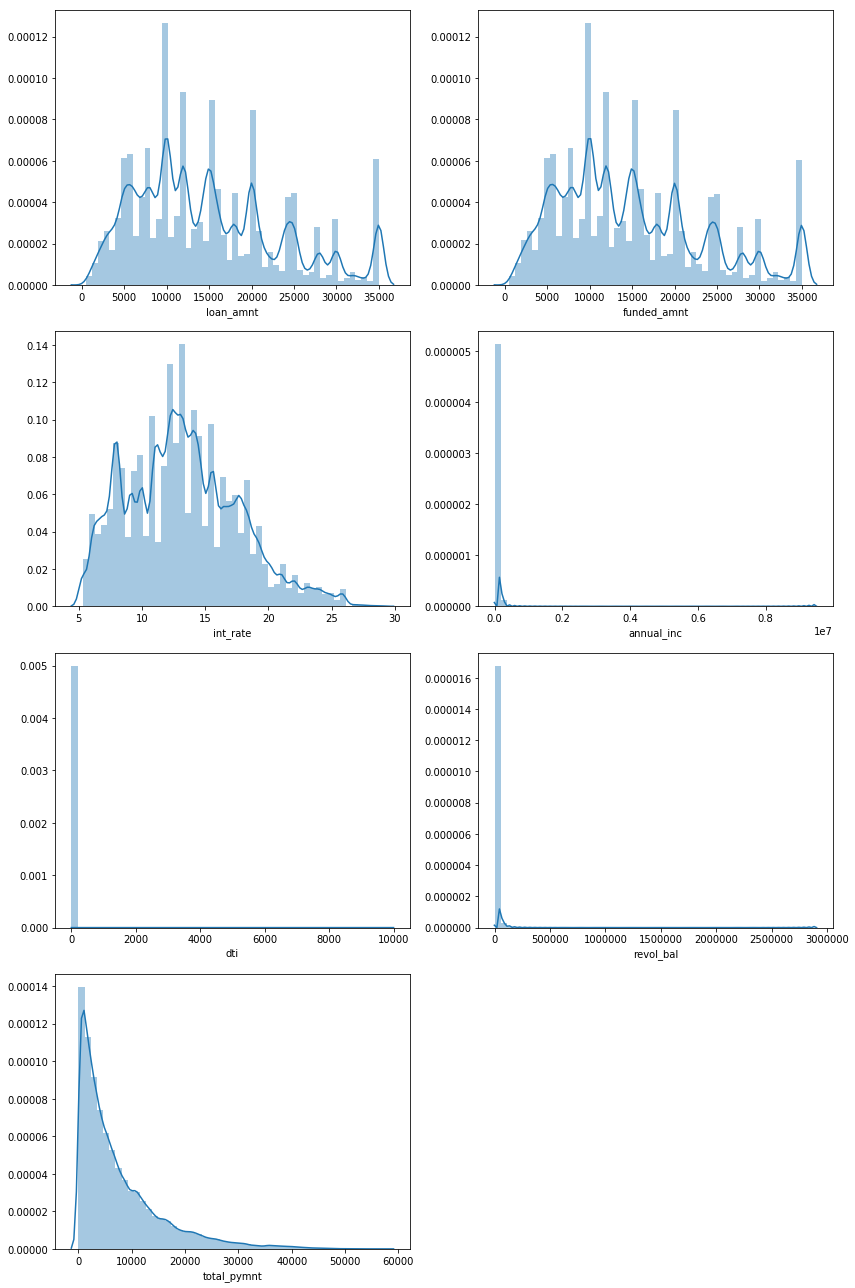

In [22]:
plot_cols = ['loan_amnt', 'funded_amnt','int_rate', 
            'annual_inc','dti', 'revol_bal', 'total_pymnt']

plt.figure(figsize=(12,18))
for i,c in enumerate(plot_cols):
    plt.subplot(4,2,i+1)
    sns.distplot(df_loan.loc[:,c])
    
plt.tight_layout()
plt.show()

loan_amnt seems normally distributed, but with a high spread, as well as funded_amnt, but seems the distribution is "normal enough" to use it for modeling later.

the annual income, dti and revol_bal are extremely skewed (for annual income in the US, this makes a lot of sense and dti is related to the annual income as well as credit balance which I would expect to be skewed) so I will perform a log transformation of them for seeing the trends better and understanding what is going on.

total pymnt has a higher density of loans skewed towards 0 total payments, for which likely either not enough payments was made yet and/or the loans underperformed (we will analyze this in the business assignment later in detail)

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


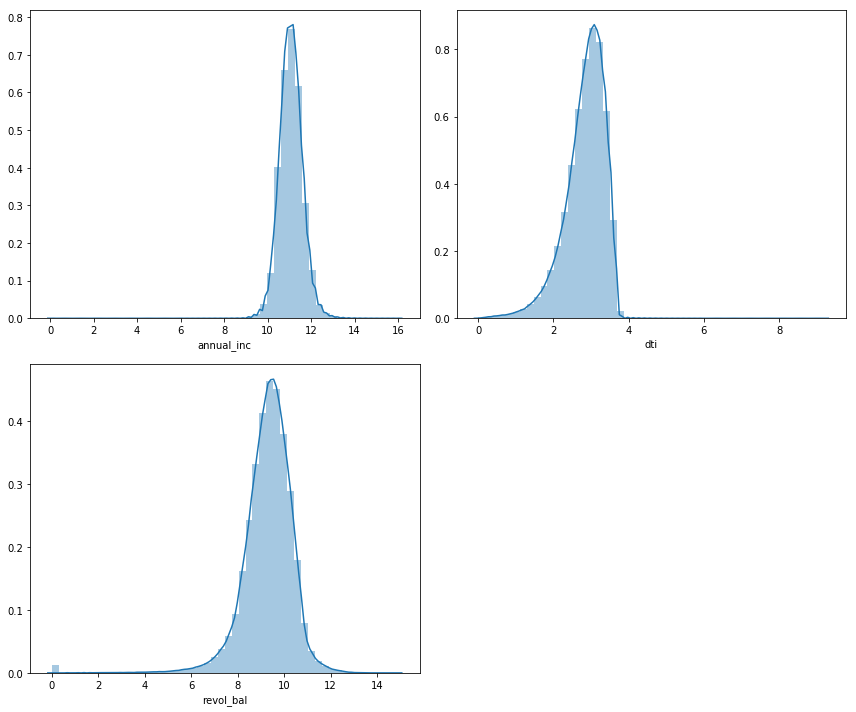

In [23]:
# log transform extremely skewed features
log_transform = ['annual_inc','dti', 'revol_bal']
plt.figure(figsize=(12,10))
for i,c in enumerate(log_transform):
    plt.subplot(2,2,i+1)
    sns.distplot(np.log(df_loan.loc[:,c]+1))
    
plt.tight_layout()
plt.show()

In [26]:
print(f'the median annual income is roughly: ${np.round(np.exp(11))}, the median dti {np.round(np.exp(2.5))} and revolvling credit balance median is ${np.round(np.exp(9))}')

the median annual income is roughly: $59874.0, the median dti 12.0 and revolvling credit balance median is $8103.0


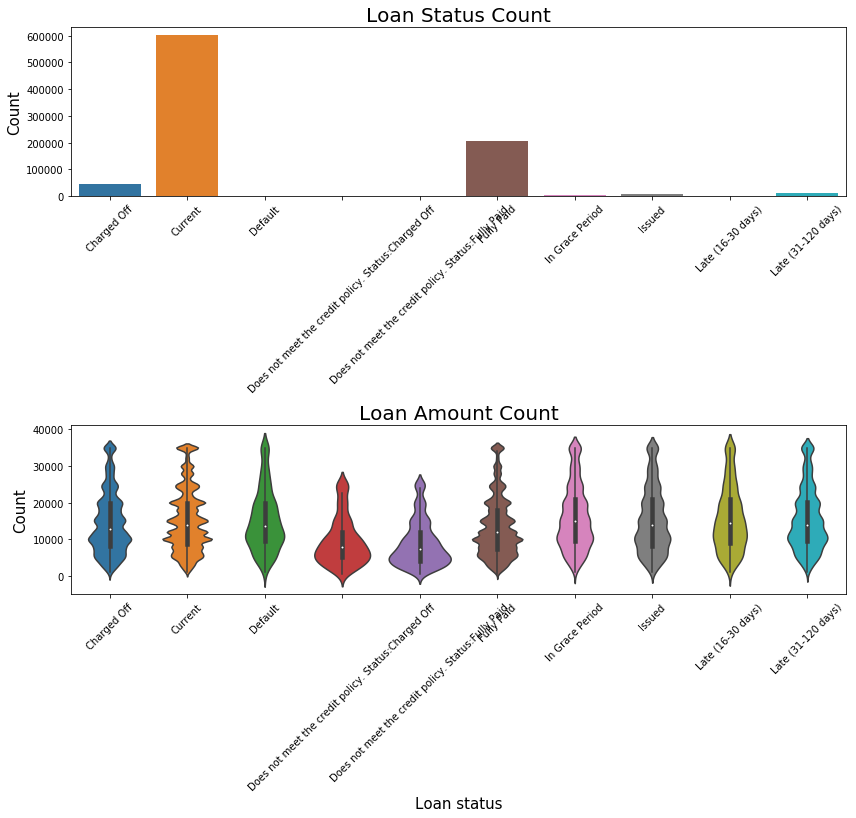

In [27]:
plt.figure(figsize = (12,14))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df_loan)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g2 = sns.violinplot(x="loan_status", y="loan_amnt", data=df_loan)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Loan status", fontsize=15)
g2.set_ylabel("Count", fontsize=15)
g2.set_title("Loan Amount Count", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)
plt.tight_layout()
plt.show()

From the countplot above, we can clearly see that the majority of loans is 'current', with a small number of loans 
fully paid or charged off.

The count of loans divided into loan status buckets exhibits somewhat normally distributed patterns, and clearly for the 'subprime' loans, the average loan amount is smaller.

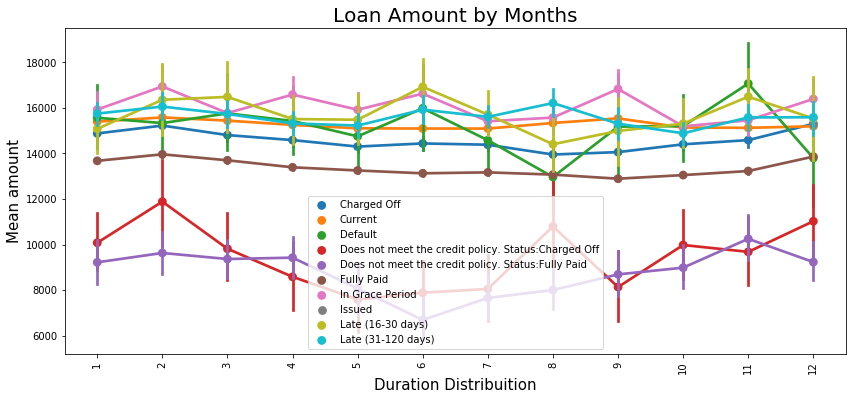

In [28]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df_loan['issue_month'] = df_loan.issue_d.dt.month

#Issue_d x loan_amount
plt.figure(figsize = (14,6))

g = sns.pointplot(x='issue_month', y='loan_amnt', 
                  data=df_loan, 
                  hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Duration Distribuition", fontsize=15)
g.set_ylabel("Mean amount", fontsize=15)
g.legend(loc='best')
g.set_title("Loan Amount by Months", fontsize=20)
plt.show()

Above, we can see the distribution of mean loan amount by months in each category of loan status.

Not suprisingly, loans which do not meet credit policy have much lower average loan amount. Of note, combining with the plot above, keep in mind that majority of the loans in this dataset are actually 'current'

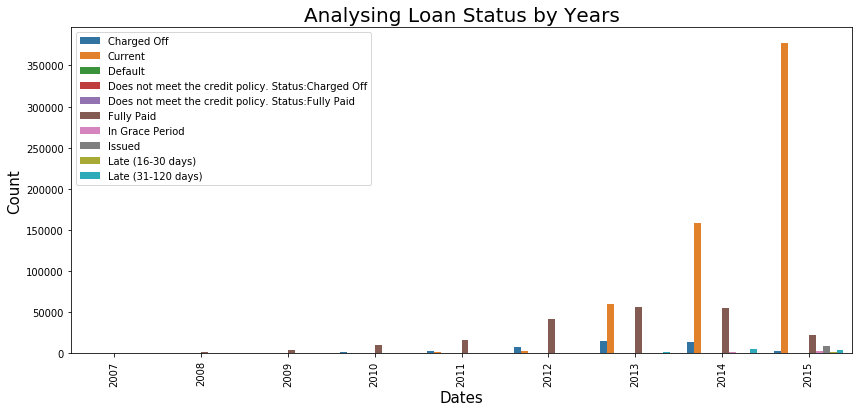

In [29]:
df_loan['issue_year'] = df_loan.issue_d.dt.year
plt.figure(figsize = (14,6))
#Looking the count of defaults though the issue_d that is The month which the loan was funded
g = sns.countplot(x='issue_year', data=df_loan,
                  hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Dates", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.legend(loc='upper left')
g.set_title("Analysing Loan Status by Years", fontsize=20)
plt.show()

We can see how the loans origination revived after 2008, and kept increasing, especially the 'current' loans

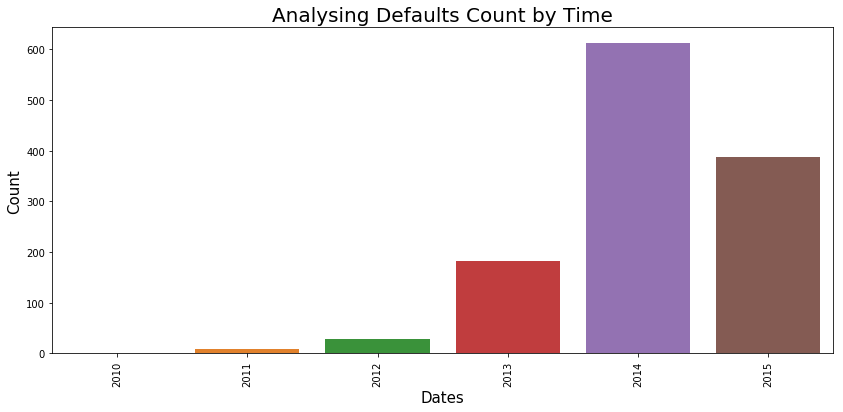

In [30]:
plt.figure(figsize = (14,6))
#Looking the count of defaults though the issue_d that is the month when the loan was funded
g = sns.countplot(x='issue_year', data=df_loan[df_loan['loan_status'] =='Default'])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Dates", fontsize=15)
g.set_ylabel("Count", fontsize=15)
#g.legend(loc='upper left')
g.set_title("Analysing Defaults Count by Time", fontsize=20)
plt.show()

Interestingly, in 2014 there was a peak in defaults on loans

## summary statistics for continuous cols



In [31]:
def get_summary_continuous(data):
    # Define metrics to be determined for each column
    metrics = []
    metrics.append(data.dtypes)
    metrics.append(data.apply(lambda x: x.nunique(), axis=0))
    
    metrics.append(data.apply(lambda x: x.isnull().sum(), axis=0))

    
    metrics.append(data.apply(lambda x: np.median(x), axis=0))
    
    metrics.append(data.apply(lambda x: np.percentile(x,25), axis=0))
    metrics.append(data.apply(lambda x: np.percentile(x,75), axis=0))
    metrics.append(data.apply(lambda x: np.std(x), axis=0))
    # Summarize
    data_meta = pd.concat(metrics, axis=1)
    data_meta.columns = ['data_type', 'count_unique', 'count_null' 
                        ,'median','25th percentile','75th percentile','std deviation']
    # we DO NOT WANT TO COUNG BLANK AS MISSING HERE
#     data_meta['ppn_missing'] = (data_meta['count_null'] + 
#                                 data_meta['count_missing_passive'] + 
#                                 data_meta['count_missing_confirmed'] + 
#                                 data_meta['count_blank']) / len(data)
    data_meta['ppn_missing'] = (data_meta['count_null'] 
                                ) / len(data)
    return data_meta

In [32]:
continuous = [col for col in df_loan.columns if df_loan[col].dtype in ['float64','int64']]

In [33]:
summary_continuous = get_summary_continuous(df_loan[list(set(continuous).difference(set(['issue_month','issue_year'])))])

In [34]:
summary_continuous 

,data_type,count_unique,count_null,median,25th percentile,75th percentile,std deviation,ppn_missing
total_pymnt,float64,506726,0,4894.999117,1914.59,10616.814231,7871.238901,0.0
funded_amnt,float64,1372,0,13000.000000,8000.00,20000.000000,8429.892907,0.0
revol_bal,float64,73740,0,11875.000000,6443.00,20829.000000,22426.779259,0.0
int_rate,float64,542,0,12.990000,9.99,16.200000,4.381865,0.0
annual_inc,float64,49385,0,65000.000000,45000.00,90000.000000,64698.118479,0.0
dti,float64,4086,0,17.650000,11.91,23.950000,17.190616,0.0
loan_amnt,float64,1372,0,13000.000000,8000.00,20000.000000,8435.450848,0.0


## summary statistics for categorical cols

In [35]:
def get_summary_categorical(data):
    # Define metrics to be determined for each column
    metrics = []
    metrics.append(data.dtypes)
    metrics.append(data.apply(lambda x: x.nunique(), axis=0))
    
    metrics.append(data.apply(lambda x: x.isnull().sum(), axis=0))

    
    metrics.append(data.apply(lambda x: np.count_nonzero(x), axis=0))
    
    # Summarize
    data_meta = pd.concat(metrics, axis=1)
    data_meta.columns = ['data_type', 'count_unique', 'count_null' 
                        ,'count']
    # we DO NOT WANT TO COUNG BLANK AS MISSING HERE
#     data_meta['ppn_missing'] = (data_meta['count_null'] + 
#                                 data_meta['count_missing_passive'] + 
#                                 data_meta['count_missing_confirmed'] + 
#                                 data_meta['count_blank']) / len(data)
    data_meta['ppn_missing'] = (data_meta['count_null'] 
                                ) / len(data)
    return data_meta

In [43]:
continuous.append('issue_d')
categorical = df_loan.columns.difference(continuous)

In [44]:
get_summary_categorical(df_loan[categorical])

,data_type,count_unique,count_null,count,ppn_missing
grade,category,7,0,887379,0.0
loan_status,category,10,0,887379,0.0
term,category,2,0,887379,0.0


# Part 2: Business Analysis

In [45]:
# we have 36 months and 60-months term loans

# for the purpose of this analysis, exclude the 60-months term loans

In [46]:
df_loan.term.unique()[0] # get rid of the empty space

' 36 months'

In [47]:
df_loan.term = df_loan.term.apply(lambda x: x.strip(' '))

In [48]:
df_36 = df_loan.loc[df_loan.term=='36 months',:]

In [49]:
df_36.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,issue_month,issue_year
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,27.65,13648.0,5861.071414,Fully Paid,12,2011
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,8.72,2956.0,3003.653644,Fully Paid,12,2011
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,20.00,5598.0,12226.302212,Fully Paid,12,2011
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,11.20,7963.0,5631.377753,Fully Paid,12,2011
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,5.35,8221.0,3938.144334,Fully Paid,12,2011


In [50]:
print(f'we have {df_36.shape[0]} of 36 months term loans available for analysis.')

we have 621125 of 36 months term loans available for analysis.


Exclude loans with less than 36 months of data available:

I look at the latest date in the dataset and assume that is the most 'current date'

Then I exlude loans which were issued after (maximum_date - 36 months) to get only loans with 36 months or more worth of data

In [51]:
cutoff_date = np.max(df_36.issue_d) - pd.Timedelta(weeks=36*4)
print(f'Exclude loans issued after {cutoff_date}')

Exclude loans issued after 2013-02-26 00:00:00


In [52]:
df_36 = df_36.loc[df_36.issue_d<=cutoff_date,:]

In [54]:
print(f'Latest loan with 36 months worth of data in current dataset issued on {df_36.issue_d.max()}')

Latest loan with 36 months worth of data in current dataset issued on 2013-02-01 00:00:00


## 1) Percentage of 36-month term loans fully paid

In [55]:
print(f'Percentage of loans fully paid: {np.round(df_36.loan_status[df_36.loan_status=="Fully Paid"].count()/df_36.loan_status.count(),3)*100}%')

Percentage of loans fully paid: 81.5%


We have about 81.5% of 36 months term loans in the dataset were fully paid. We know that the 36-months term for all of the loans in the subset has passed (as of 2013-02-26). 

## 2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”.

In [56]:
def default_rate(x):
    defaults = 0
    for i in x:
        if i != "Fully Paid":
            defaults+=1
    return defaults/len(x)

In [57]:
cohorts = df_36.groupby(['issue_year','grade']).agg({'loan_status': \
                                           lambda x: default_rate(x)}).sort_values(by='loan_status',ascending=False)

In [58]:
cohorts.head()

loan_status
issue_year grade             
2007       G         1.000000
2008       G         0.976744
2007       E         0.910000
           F         0.903846
2008       F         0.900901

Clearly, the 2007 and 2008 rate G cohorts defaulted almost in all cases... which makes a lot of sense given the Great Financial Crisis.

## 3 When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?
For simplicity, use the following approximation:
Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1

In [59]:
df_36.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc',
       'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status',
       'issue_month', 'issue_year'],
      dtype='object')

In [60]:
return_groupby = df_36.groupby(['issue_year','grade'])

In [61]:
def avg_annual_ror(return_groupby):
    result_dict = {}
    for i in return_groupby:
        # i[0] is the groupby label, i[1] dataframe for that label
        ror = (i[1]['total_pymnt']/i[1]['funded_amnt'])**(1/3)-1
        result_dict[i[0]] = ror.mean()
    return result_dict

In [62]:
result = avg_annual_ror(return_groupby)

In [64]:
def build_dataframe_result(result):
    year_origination = [i[0] for i in result.keys()]
    grade = [i[1] for i in result.keys()]
    rate_of_return = [i for i in result.values()] 

    return dict(year_origination=year_origination,loan_grade=grade,rate_of_return=rate_of_return)

In [65]:
final_df = pd.DataFrame(build_dataframe_result(result))

In [66]:
final_df = final_df.sort_values(by='rate_of_return',ascending=False)

In [67]:
final_df.head()

,year_origination,loan_grade,rate_of_return
41,2012,G,0.042904
40,2012,F,0.032257
39,2012,E,0.031771
44,2013,C,0.027889
0,2007,A,0.027138


In [68]:
final_df.iloc[-5:,:]

,year_origination,loan_grade,rate_of_return
10,2008,D,-0.018365
34,2011,G,-0.020399
6,2007,G,-0.044102
12,2008,F,-0.045138
5,2007,F,-0.079863


Based on our analysis, 3 best-performing 36-month term loans were issued in 2012 with grades G,F, and E, respectively.

On the flip side, the worst-performing 36-month term loans were issued in 2008,2011,and 2007, respectively, with respective grades D,G, and G.